In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath('.')))

In [2]:
import torch

from data.dataset import YOLODataset, PASCAL_CLASSES
from data.transform import get_yolo_transform

from model.yolov3 import YOLOv3

from utils.convert import cells_to_bboxes
from utils.cleanup import non_max_suppression as nms
from utils.display import plot_image

%load_ext autoreload
%autoreload 2

In [3]:
CSV_PATH = "../download/PASCAL_VOC/test.csv"
IMG_DIR = "../download/PASCAL_VOC/images/"
LABEL_DIR = "../download/PASCAL_VOC/labels/"

In [4]:
DEVICE = "cuda"
IMG_SIZE = 416
SCALES = [13, 26, 52]
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
] # (3, 3, 2)

In [5]:
transform = get_yolo_transform(img_size=IMG_SIZE, mode='test')
dataset = YOLODataset(csv_file=CSV_PATH,
                      img_dir=IMG_DIR,
                      label_dir=LABEL_DIR,
                      anchors=ANCHORS,
                      transform=transform)

In [6]:
img, targets = dataset[20]
img = img.to(DEVICE)

In [7]:
model = YOLOv3(in_channels=3, num_classes=20)
checkpoint = torch.load('../run/yolov3_voc/best.pth')
model.load_state_dict(checkpoint['model'])
model = model.to(DEVICE)
model = model.eval()
print("ACC:", checkpoint['current_acc'])
print("mAP:", checkpoint['current_map'])

ACC: {'cls': 91.80937194824219, 'obj': 91.32169342041016, 'noobj': 98.26599884033203}
mAP: 0.7047429084777832


In [8]:
scaled_anchors = torch.tensor(ANCHORS)*torch.tensor(SCALES).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
scaled_anchors = scaled_anchors.to(DEVICE)

In [9]:
out = model(img.unsqueeze(0))

In [10]:
pred_bboxes = []
for scale_idx in range(len(out)):                                   
    pred = out[scale_idx]               
    curr_scale = pred.size(2) # pred: (N, 3, S, S, 5+classes)       
    curr_anchors = scaled_anchors[scale_idx] # curr_anchor: (3, 2)
    bboxes = cells_to_bboxes(preds=pred,                          
                            scale=curr_scale,                       
                            anchors=curr_anchors)[0]
    mask = bboxes[..., 1] > 0.2
    valid_bboxes = bboxes[mask]
    pred_bboxes += valid_bboxes.detach().cpu().numpy().tolist()

In [11]:
nms_pred_bboxes = nms(pred_bboxes,
                     iou_threshold=0.45,
                     prob_threshold=0.6,
                     classes=[ i for i in range(20) ],
                     box_format='xywh')

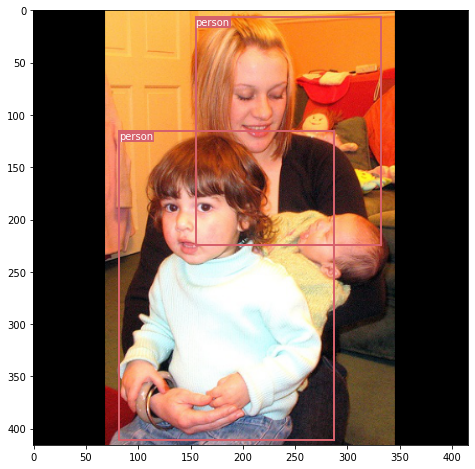

In [12]:
plot_image(img.permute(1, 2, 0).to("cpu"), nms_pred_bboxes, PASCAL_CLASSES)